In [4]:
import json
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import Counter, defaultdict
import numpy as np
from datetime import datetime, timedelta

# Helper function to load blocks from a JSON file
def load_blocks(filename):
    with open(filename, 'r') as f:
        return json.load(f)

# Convert seconds to a readable timedelta format
def format_seconds(seconds):
    return str(timedelta(seconds=int(seconds)))

# Analyze a list of blocks
def analyze_blocks(blocks):
    timestamps = [block['timestamp'] for block in blocks]
    difficulties = [block['difficulty'] for block in blocks]
    miners = [str(block.get('miner_id')) for block in blocks if block.get('miner_id') is not None]

    miner_counts = Counter(miners)
    miner_values = list(miner_counts.values())

    # Consecutive block analysis
    max_streak = 0
    current_streak = 1
    for i in range(1, len(blocks)):
        prev = blocks[i - 1].get('miner_id')
        curr = blocks[i].get('miner_id')
        if curr == prev:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 1

    block_times = [timestamps[i] - timestamps[i - 1] for i in range(1, len(timestamps))]
    block_times_sec = [bt / 1000 for bt in block_times]  # convert ms to s

    return {
        'total_time_sec': (timestamps[-1] - timestamps[1]) / 1000,
        'mean_difficulty': np.mean(difficulties),
        'miner_distribution': dict(miner_counts),
        'mean_blocks_per_miner': np.mean(miner_values) if miner_values else 0,
        'std_dev_blocks_per_miner': np.std(miner_values) if miner_values else 0,
        'block_time_mean': np.mean(block_times_sec) if block_times_sec else 0,
        'block_time_std': np.std(block_times_sec) if block_times_sec else 0,
    }

# Print comparison between two sets of statistics
def compare_stats(stat1, stat2, label1="With Rules", label2="Without Rules"):
    print(f"\n📊 Comparison: {label1} vs {label2}")
    for key in stat1:
        v1 = stat1[key]
        v2 = stat2.get(key, None)

        if key == 'total_time_sec':
            print(f"{key:>30}: {format_seconds(v1)} vs {format_seconds(v2)}")
        elif isinstance(v1, float):
            print(f"{key:>30}: {v1:.2f} vs {v2:.2f}")
        elif isinstance(v1, dict):
            print(f"\n{key} (Miner Distribution):")
            all_miners = sorted(set(v1.keys()) | set(v2.keys()))
            for miner in all_miners:
                print(f"  Miner {miner}: {v1.get(miner, 0)} vs {v2.get(miner, 0)}")
        else:
            print(f"{key:>30}: {v1} vs {v2}")

# Replace with your file paths
blocks_with_rules = load_blocks('../blockchain with rules with power.json')
blocks_without_rules = load_blocks('../blockchain without rules with power.json')

stats_with = analyze_blocks(blocks_with_rules)
stats_without = analyze_blocks(blocks_without_rules)

compare_stats(stats_with, stats_without)



📊 Comparison: With Rules vs Without Rules
                total_time_sec: 0:47:06 vs 0:39:27
               mean_difficulty: 4.11 vs 3.74

miner_distribution (Miner Distribution):
  Miner 3001: 237 vs 487
  Miner 3002: 191 vs 277
  Miner 3003: 139 vs 24
  Miner 3004: 79 vs 33
  Miner 3005: 61 vs 42
  Miner 3006: 83 vs 10
  Miner 3007: 88 vs 11
  Miner 3008: 29 vs 9
  Miner 3009: 23 vs 12
         mean_blocks_per_miner: 103.33 vs 100.56
      std_dev_blocks_per_miner: 68.18 vs 158.73
               block_time_mean: 1881272.45 vs 1933245.10
                block_time_std: 57340153.34 vs 58126014.48


   Shannon Entropy  Gini Coefficient  Nakamoto Coefficient       HHI
0         2.871543          0.422664                     3  0.159141


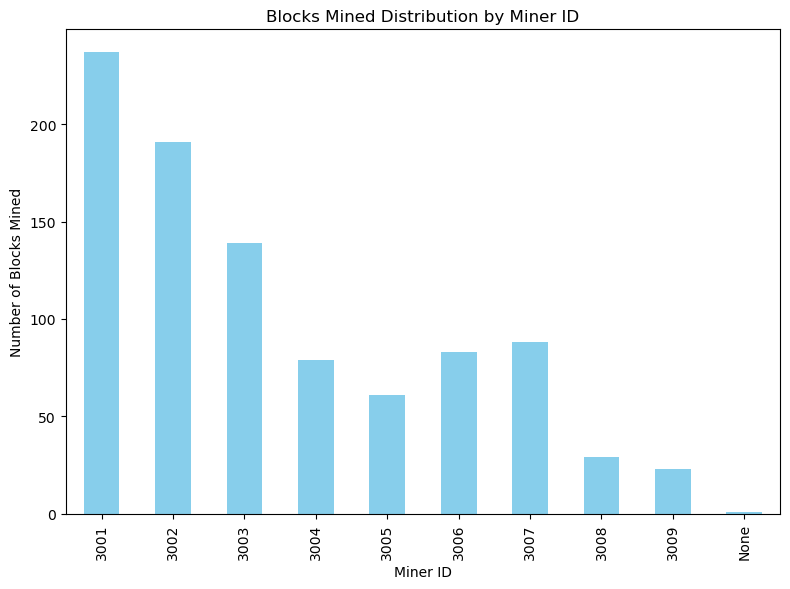

In [5]:
import pandas as pd
import numpy as np
import json
import glob
import matplotlib.pyplot as plt

# ----------------------------
# Metric Functions
# ----------------------------

def shannon_entropy(probabilities):
    """Calculates the Shannon entropy given a probability distribution."""
    probabilities = probabilities[probabilities > 0]  # Remove zero probabilities
    return -np.sum(probabilities * np.log2(probabilities))

def gini_coefficient(values):
    """Calculates the Gini coefficient for a list/array of values."""
    if len(values) == 0:
        return np.nan
    sorted_vals = np.sort(values)
    n = len(sorted_vals)
    cumvals = np.cumsum(sorted_vals)
    if cumvals.size == 0 or cumvals[-1] == 0:
        return np.nan
    return (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n

def nakamoto_coefficient(distribution, threshold=0.51):
    """
    Calculates the Nakamoto coefficient. It sorts the miner distribution
    and determines the minimum number of miners required to exceed 
    the given cumulative share threshold.
    """
    total = distribution.sum()
    if total == 0:
        return np.nan
    sorted_distribution = distribution.sort_values(ascending=False)
    cumulative_share = sorted_distribution.cumsum() / total
    return (cumulative_share < threshold).sum() + 1

def herfindahl_hirschman_index(distribution):
    """Calculates the Herfindahl-Hirschman Index (HHI) for the distribution."""
    total = distribution.sum()
    if total == 0:
        return np.nan
    shares = distribution / total
    return np.sum(shares ** 2)

# ----------------------------
# Data Loading & Extraction
# ----------------------------

def load_blocks_data(json_files):
    """
    Loads JSON files and returns a combined list of blocks.
    It flattens the list if a file contains an array of blocks.
    """
    blocks_data = []
    for file in json_files:
        with open(file, 'r') as f:
            block = json.load(f)
            if isinstance(block, list):
                blocks_data.extend(block)
            else:
                blocks_data.append(block)
    return blocks_data

def extract_block_counts(blocks):
    """
    Counts the number of blocks mined by each miner.
    Uses the 'miner_id' field as the miner identifier.
    """
    counts = {}
    for block in blocks:
        miner_id = str(block.get("miner_id"))
        counts[miner_id] = counts.get(miner_id, 0) + 1
    return pd.Series(counts)

# ----------------------------
# Main Workflow
# ----------------------------

# Update the path below to point to your JSON file(s)
json_files = glob.glob("blockchain with rules with power.json")
blocks = load_blocks_data(json_files)

# Aggregate the count of blocks per miner_id
block_distribution = extract_block_counts(blocks)

if block_distribution.empty:
    print("No blocks found in the dataset.")
    results = {
        'Shannon Entropy': np.nan,
        'Gini Coefficient': np.nan,
        'Nakamoto Coefficient': np.nan,
        'HHI': np.nan
    }
else:
    # Calculate probabilities based on block counts per miner
    probabilities = block_distribution / block_distribution.sum()
    
    entropy = shannon_entropy(probabilities)
    gini = gini_coefficient(block_distribution.values)
    nakamoto = nakamoto_coefficient(block_distribution)
    hhi = herfindahl_hirschman_index(block_distribution)
    
    results = {
        'Shannon Entropy': entropy,
        'Gini Coefficient': gini,
        'Nakamoto Coefficient': nakamoto,
        'HHI': hhi
    }

# Display the results in a DataFrame
print(pd.DataFrame([results]))

# ----------------------------
# Optional: Plotting the Distribution
# ----------------------------

if not block_distribution.empty:
    plt.figure(figsize=(8, 6))
    block_distribution.sort_index().plot(kind='bar', color='skyblue')
    plt.title('Blocks Mined Distribution by Miner ID')
    plt.xlabel('Miner ID')
    plt.ylabel('Number of Blocks Mined')
    plt.tight_layout()
    plt.show()


   Shannon Entropy  Gini Coefficient  Nakamoto Coefficient       HHI
0         1.830941          0.716115                     1  0.387135


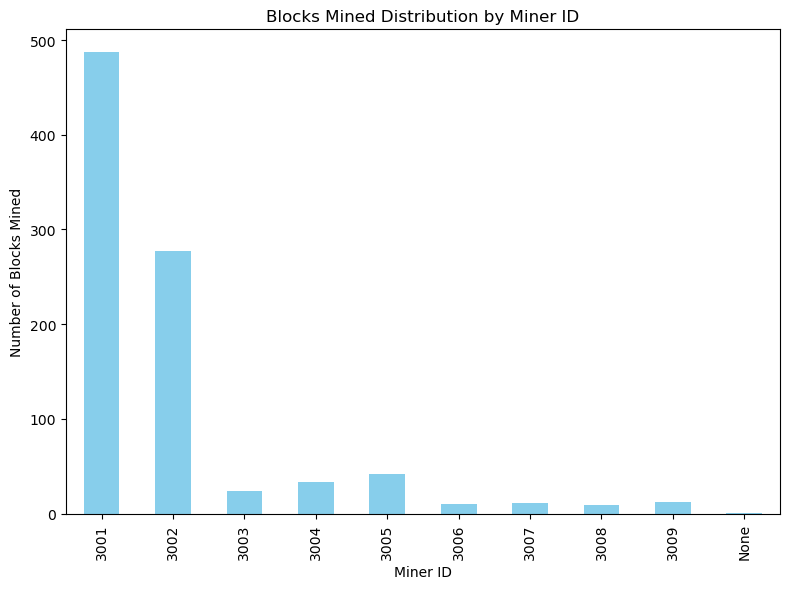

In [6]:
import pandas as pd
import numpy as np
import json
import glob
import matplotlib.pyplot as plt

# ----------------------------
# Metric Functions
# ----------------------------

def shannon_entropy(probabilities):
    """Calculates the Shannon entropy given a probability distribution."""
    probabilities = probabilities[probabilities > 0]  # Remove zero probabilities
    return -np.sum(probabilities * np.log2(probabilities))

def gini_coefficient(values):
    """Calculates the Gini coefficient for a list/array of values."""
    if len(values) == 0:
        return np.nan
    sorted_vals = np.sort(values)
    n = len(sorted_vals)
    cumvals = np.cumsum(sorted_vals)
    if cumvals.size == 0 or cumvals[-1] == 0:
        return np.nan
    return (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n

def nakamoto_coefficient(distribution, threshold=0.51):
    """
    Calculates the Nakamoto coefficient. It sorts the miner distribution
    and determines the minimum number of miners required to exceed 
    the given cumulative share threshold.
    """
    total = distribution.sum()
    if total == 0:
        return np.nan
    sorted_distribution = distribution.sort_values(ascending=False)
    cumulative_share = sorted_distribution.cumsum() / total
    return (cumulative_share < threshold).sum() + 1

def herfindahl_hirschman_index(distribution):
    """Calculates the Herfindahl-Hirschman Index (HHI) for the distribution."""
    total = distribution.sum()
    if total == 0:
        return np.nan
    shares = distribution / total
    return np.sum(shares ** 2)

# ----------------------------
# Data Loading & Extraction
# ----------------------------

def load_blocks_data(json_files):
    """
    Loads JSON files and returns a combined list of blocks.
    It flattens the list if a file contains an array of blocks.
    """
    blocks_data = []
    for file in json_files:
        with open(file, 'r') as f:
            block = json.load(f)
            if isinstance(block, list):
                blocks_data.extend(block)
            else:
                blocks_data.append(block)
    return blocks_data

def extract_block_counts(blocks):
    """
    Counts the number of blocks mined by each miner.
    Uses the 'miner_id' field as the miner identifier.
    """
    counts = {}
    for block in blocks:
        miner_id = str(block.get("miner_id"))
        counts[miner_id] = counts.get(miner_id, 0) + 1
    return pd.Series(counts)

# ----------------------------
# Main Workflow
# ----------------------------

# Update the path below to point to your JSON file(s)
json_files = glob.glob("blockchain without rules with power.json")
blocks = load_blocks_data(json_files)

# Aggregate the count of blocks per miner_id
block_distribution = extract_block_counts(blocks)

if block_distribution.empty:
    print("No blocks found in the dataset.")
    results = {
        'Shannon Entropy': np.nan,
        'Gini Coefficient': np.nan,
        'Nakamoto Coefficient': np.nan,
        'HHI': np.nan
    }
else:
    # Calculate probabilities based on block counts per miner
    probabilities = block_distribution / block_distribution.sum()
    
    entropy = shannon_entropy(probabilities)
    gini = gini_coefficient(block_distribution.values)
    nakamoto = nakamoto_coefficient(block_distribution)
    hhi = herfindahl_hirschman_index(block_distribution)
    
    results = {
        'Shannon Entropy': entropy,
        'Gini Coefficient': gini,
        'Nakamoto Coefficient': nakamoto,
        'HHI': hhi
    }

# Display the results in a DataFrame
print(pd.DataFrame([results]))

# ----------------------------
# Optional: Plotting the Distribution
# ----------------------------

if not block_distribution.empty:
    plt.figure(figsize=(8, 6))
    block_distribution.sort_index().plot(kind='bar', color='skyblue')
    plt.title('Blocks Mined Distribution by Miner ID')
    plt.xlabel('Miner ID')
    plt.ylabel('Number of Blocks Mined')
    plt.tight_layout()
    plt.show()

